## Approach Used: 

### Inputs

In [1]:
import matplotlib.pyplot as plt
import re
import os
%matplotlib inline


import argparse
import pickle

import numpy as np; np.seterr(invalid='ignore')
import pandas as pd

In [2]:
print(os.listdir('../input/'))

['modelweights', 'web-traffic-time-series-forecasting']


### Initial EDA

In [3]:
train = pd.read_csv('../input/web-traffic-time-series-forecasting/train_1.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [5]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

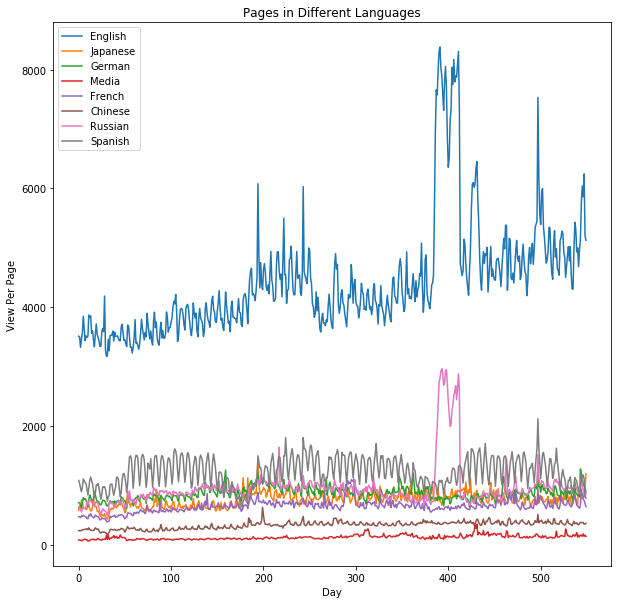

In [6]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel('View Per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

### Creating Medians of Fibonacci

In [7]:
parser = {
    'offset': 803,
    'val_len': 64,
    'seed': 20170913,
    'windows': [7, 14, 21, 35, 56, 91, 147, 238, 385, 623],
    'forecast_start': '2017-09-11',
    'forecast_end': '2017-11-13'
}
args = argparse.Namespace(**parser)

In [8]:
def smape(y_pred, y_true):
    y_pred = np.around(y_pred)
    denominator = y_true + y_pred
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0
    return 200 * np.nanmean(diff)

In [9]:
print("Getting data...")
full = pd.read_csv('../input/web-traffic-time-series-forecasting/train_2.csv')
full.iloc[:, 1:] = full.iloc[:, 1:].fillna(method='ffill', axis=1).fillna(
        method='bfill', axis=1)
datetime_list = pd.date_range(args.forecast_start, args.forecast_end)
for datetime in datetime_list:
    full[datetime.date().isoformat()] = 0

print("Constructing test set...")
test = pd.melt(full[list(
    full.columns[args.offset+1:args.offset+args.val_len+1])+['Page']],
    id_vars='Page', var_name='Date', value_name="Visits")
test['Date'] = test['Date'].astype('datetime64[ns]')
test['Weekend'] = test['Date'].dt.dayofweek >= 5

print("Constructing train set...")
train = full.iloc[:, :args.offset+1]

print("Getting medians...")
for i in args.windows:
    print(i, end=' ')
    val = 'MW'+str(i)
    tmp = pd.melt(train[list(train.columns[-i:])+['Page']],
                  id_vars='Page', var_name='Date', value_name=val)
    tmp['Date'] = tmp['Date'].astype('datetime64[ns]')
    tmp['Weekend']= tmp['Date'].dt.dayofweek >= 5           
    tmp1 = tmp.groupby(['Page', 'Weekend']).median().reset_index()
    test = test.merge(tmp1, how='left')
print("\n")

print("Getting median of medians...")
test['Predict'] = test[["MW7", "MW7", "MW14", "MW21", "MW35", "MW56", "MW91",
    "MW147", "MW238", "MW385", "MW623"]].median(axis=1)

Getting data...
Constructing test set...
Constructing train set...
Getting medians...
7 14 21 35 56 91 147 238 385 623 

Getting median of medians...


In [10]:
os.makedirs('../working/{}'.format(args.seed))

In [11]:
print(os.listdir('../working'))

['__notebook__.ipynb', '__output__.json', '20170913']


In [12]:
with open("../working/{}/pred_fib.pkl".format(args.seed), "wb") as f:
    predict_df = test[["Page", "Date", "Predict"]].pivot(
        index='Page', columns='Date')['Predict'].loc[full["Page"]]
    pickle.dump(predict_df.values, f)

### Now predicting using LSTM

In [13]:
import os
import argparse
import pickle
import time

import numpy as np; np.seterr(invalid='ignore')
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import TensorDataset, DataLoader

In [14]:
parser = {
    'data_path': '../input/web-traffic-time-series-forecasting/',
    'train_file': 'train_2.csv',
    'key_file': 'key_2.csv',
    'intermediate_path': '../working/',
    'train_len': 385,
    'train_skip': 91,
    'val_len': 64,
    'offset': 803,
    'batch_size': 256,
    'hidden_size': 256,
    'log_every': 10,
    'read_from_file': False,
    'train': False,
    'model_name': '',
    'forecast': True,
    'cuda': True,
    'seed': 20170913,
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

args.intermediate_path = os.path.join(args.intermediate_path, str(args.seed))


In [15]:
class DenseLSTMForecast(nn.Module):
    def __init__(self, hidden_size):
        super(DenseLSTMForecast, self).__init__()
        self.lstm1 = nn.LSTMCell(1, hidden_size)
        self.lstm2 = nn.LSTMCell(hidden_size+1, hidden_size)
        self.lstm3 = nn.LSTMCell(2*hidden_size+1, hidden_size)
        self.linear = nn.Linear(3*hidden_size+1, 1)
        self.hidden_size = hidden_size

    def forward(self, x, future=0):
        o = []
        tt = torch.cuda if args.cuda else torch
        h1_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c1_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        h2_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c2_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        h3_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        c3_t = Variable(tt.FloatTensor(x.size(0), self.hidden_size).zero_())
        
        for x_t in x.chunk(x.size(1), dim=1):
            x_t = x_t.squeeze(dim=1)
            h1_t, c1_t = self.lstm1(x_t, (h1_t, c1_t))
            h1d_t = torch.cat([x_t, h1_t], dim=1)
            h2_t, c2_t = self.lstm2(h1d_t, (h2_t, c2_t))
            h2d_t = torch.cat([x_t, h1_t, h2_t], dim=1)
            h3_t, c3_t = self.lstm3(h2d_t, (h3_t, c3_t))
            h3d_t = torch.cat([x_t, h1_t, h2_t, h3_t], dim=1)
            o_t = self.linear(h3d_t)
            o.append(o_t)

            
        for i in range(future):
            h1_t, c1_t = self.lstm1(o_t, (h1_t, c1_t))
            h1d_t = torch.cat([o_t, h1_t], dim=1)
            h2_t, c2_t = self.lstm2(h1d_t, (h2_t, c2_t))
            h2d_t = torch.cat([o_t, h1_t, h2_t], dim=1)
            h3_t, c3_t = self.lstm3(h2d_t, (h3_t, c3_t))
            h3d_t = torch.cat([o_t, h1_t, h2_t, h3_t], dim=1)
            o_t = self.linear(h3d_t)
            o.append(o_t)

        return torch.stack(o, dim=1)

In [16]:
def get_data():
    raw_data_file = os.path.join(args.intermediate_path, 'raw_data.pkl')
    scaled_data_file = os.path.join(args.intermediate_path,
                                    'scaled_data.pkl')
    scaler_file = os.path.join(args.intermediate_path, 'scaler.pkl')
    
    if not args.read_from_file:
        data_df = pd.read_csv(os.path.join(args.data_path, args.train_file),
                              index_col='Page')
        raw_data = data_df.values.copy()
        data_df = data_df.fillna(method='ffill', axis=1).fillna(
            method='bfill', axis=1)
        data = np.nan_to_num(data_df.values.astype('float32'))
        data = np.log1p(data)
        scaler = StandardScaler()
        scaler.fit(np.swapaxes(data, 0, 1))
        scaled_data = scaler.transform(np.swapaxes(data, 0, 1))
        scaled_data = np.swapaxes(scaled_data, 0, 1)
        
        with open(raw_data_file, 'wb') as f:
            pickle.dump(raw_data, f)
        with open(scaled_data_file, 'wb') as f:
            pickle.dump(scaled_data, f)
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
    else:
        with open(raw_data_file, 'rb') as f:
            raw_data = pickle.load(f)
        with open(scaled_data_file, 'rb') as f:
            scaled_data = pickle.load(f)
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
    return raw_data, scaled_data, scaler

In [17]:
def train(raw_data, scaled_data, scaler, model, criterion, optimizer):
    p = np.random.permutation(scaled_data.shape[0])
    inverse_p = np.argsort(p)
    
    input_tensor = torch.from_numpy(
        scaled_data[p, :(args.offset-1)]).unsqueeze(2)
    target_tensor = torch.from_numpy(
        scaled_data[p, 1:args.offset]).unsqueeze(2)
    dataset = TensorDataset(input_tensor, target_tensor)
    data_loader = DataLoader(dataset, args.batch_size)
    
    train_loss = 0
#    val_output_list = []
    init_time = time.time()
    for i, (inputt, target) in enumerate(data_loader):
        if args.cuda:
            inputt = inputt.cuda()
            target = target.cuda()
        inputt = Variable(inputt)
        target = Variable(target)
        
#        output = model(inputt, future=args.val_len)
        output = model(inputt)
        pos = np.random.randint(args.train_skip,
                                inputt.size(1)-args.train_len+1)
        loss = criterion(output[:, pos:pos+args.train_len],
                         target[:, pos:pos+args.train_len])
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), 3, 'inf')
        optimizer.step()
        train_loss += loss.item() * inputt.size(0)
#        val_output_list.append(output[:, -args.val_len:]
#                               .data.squeeze(2).cpu().numpy())
        
        if i % args.log_every == 0:
            print("   % Time: {:4.0f}s | Batch: {:4} | "
                  "Train loss: {:.4f}".format(
                      time.time()-init_time, i+1, loss.item()))
        
#    val_output_all = np.concatenate(val_output_list, axis=0)[inverse_p]
#    prediction = np.swapaxes(scaler.inverse_transform(
#           np.swapaxes(val_output_all, 0, 1)), 0, 1)
#    prediction = np.clip(np.exp(prediction)-1, 0, None)
#    var_target = raw_data[:, args.offset:args.offset+args.val_len]
    
    train_loss /= scaled_data.shape[0]
#    val_loss = smape(prediction, var_target)
    val_loss = 0
    print("="*10)
    print("   % Epoch: {} | Time: {:4.0f}s | "
          "Train loss: {:.4f} | Val loss: {:.4f}"
          .format(epoch, time.time()-init_time, train_loss, val_loss))
    print("="*10)
    return val_loss

In [18]:
def forecast(raw_data, scaled_data, scaler, model):
    input_tensor = torch.from_numpy(scaled_data[:,
            :args.offset]).unsqueeze(2)
    target_tensor = torch.zeros(input_tensor.size(0))
    dataset = torch.utils.data.TensorDataset(input_tensor, target_tensor)
    data_loader = DataLoader(dataset, 128)
    
    output_list = []
    for i, (inputt, _) in enumerate(data_loader):
        if args.cuda:
            inputt = inputt.cuda()
        inputt = Variable(inputt)
        output = model(inputt, args.val_len)
        output_list.append(output.data.squeeze(2).cpu().numpy()
                           [:, -args.val_len:])
        
    output_all = np.concatenate(output_list, axis=0)
    prediction = np.swapaxes(scaler.inverse_transform(
            np.swapaxes(output_all, 0, 1)), 0, 1)

    prediction = np.clip(np.exp(prediction) - 1, 0, None)
    return prediction

In [19]:
def save_model(model, epoch, loss):
    model_file = os.path.join(args.intermediate_path,
                              "model_{}_epoch{}_loss{:.4f}.pth"
                              .format(args.seed, epoch, loss))
    torch.save(model.state_dict(), os.path.join(model_file))


In [20]:
raw_data, scaled_data, scaler = get_data()

In [21]:
model = DenseLSTMForecast(args.hidden_size)
if args.cuda:
    model.cuda()
criterion = nn.L1Loss()

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[2, 4])

In [23]:
if args.train:
    for epoch in range(1, 7):
        scheduler.step()
        print("=> EPOCH {} with lr {}".format(epoch, scheduler.get_lr()))
        val_loss = train(raw_data, scaled_data, scaler,
                         model, criterion, optimizer)
        save_model(model, epoch, val_loss)
else:
    #model_file = os.path.join(args.intermediate_path, args.model_name)
    model.load_state_dict(torch.load('../input/modelweights/model_e6.pth'))

In [24]:
if args.forecast:
    print('Predicting....')
    prediction = forecast(raw_data, scaled_data, scaler, model)
#     print("SMAPE: {}".format(smape(prediction, raw_data[:,
#        args.offset:args.offset+args.val_len])))
    with open(os.path.join(args.intermediate_path,
                           "pred_rnn.pkl"), "wb") as f:
        pickle.dump(prediction, f)

Predicting....


### Ensembling the Predictions

In [25]:
parser = {
    'offset': 803,
    'test_len': 63,
    'seed': 20170913,
    'forecast_start': '2017-09-13',
    'forecast_end': '2017-11-13'
}
args = argparse.Namespace(**parser)

In [26]:
def ensemble(pred_fib, pred_rnn, y_true):
    for i in range(0, 11):
        y_pred = (pred_fib * i + pred_rnn * (10 - i)) / 10
        print("{} fib + {} rnn = {}".format(i, 10-i, smape(y_pred, y_true)))

In [27]:
full = pd.read_csv('../input/web-traffic-time-series-forecasting/train_2.csv', index_col='Page')
y_true = full.iloc[:, -args.test_len:].values

In [28]:
with open("../working/{}/pred_fib.pkl".format(args.seed), "rb") as f:
    pred_fib = pickle.load(f)
with open("../working/{}/pred_rnn.pkl".format(args.seed), "rb") as f:
    pred_rnn = pickle.load(f)
    
prediction = (pred_rnn + pred_fib) / 2

In [29]:
test = pd.DataFrame()
test["Page"] = full.index
datetime_list = pd.date_range(args.forecast_start, args.forecast_end)
for datetime in datetime_list:
    test[datetime.date().isoformat()] = 0
test.iloc[:, 1:] = np.around(prediction[:, 2:])

In [30]:
test = pd.melt(test, id_vars='Page', var_name='Date', value_name="Visits")

key_df = pd.read_csv('../input/web-traffic-time-series-forecasting/key_2.csv')
key_df['Date'] = key_df['Page'].apply(lambda a: a[-10:])
key_df['Page'] = key_df['Page'].apply(lambda a: a[:-11])
key_df = key_df.merge(test, how="left")

key_df[['Id', 'Visits']].to_csv(
    '../working/{}/submission.csv'.format(args.seed), index=False)

In [31]:
key_df.head()

,Page,Id,Date,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,512.0
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,514.0
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,515.0
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16,559.0
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17,559.0
